In [1]:
import json
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd

C:\Users\tijme\anaconda3\envs\geospatial\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding the rerieved concepts

In [2]:
#Lets load the concepts from the json file
with open('ipcc_concepts.json', 'r', encoding='utf-8') as f:
    concepts = json.load(f)

#in the json file, concepts and their descriptions are stored as a list of dictionaries
# To get proper fixed query embeddings for our retrieval pipeline, we will concatenate the concept name and description
concept_texts = [f"{concept['concept']}: {concept['definition']}" for concept in concepts]
concept_names = [concept['concept'] for concept in concepts]

In [3]:
# Embedding with the same three models we used for the MP's
model_name1 = 'sentence-transformers/LaBSE'
model1 = SentenceTransformer(model_name1)

model_name2 = 'sentence-transformers/all-MiniLM-L6-v2'
model2 = SentenceTransformer(model_name2)

model_name3 = 'sentence-transformers/all-mpnet-base-v2'
model3 = SentenceTransformer(model_name3)

In [4]:
concept_embeddings_LaBSE = model1.encode(concept_texts, convert_to_tensor=True) # Embedding with model 1
# convert_to_tensor=True ensures the output is a tensor, this makes it easier to work with for similarity search

concept_embeddings_MiniLM = model2.encode(concept_texts, convert_to_tensor=True) # Embedding with model 2

concept_embeddings_MPNet = model3.encode(concept_texts, convert_to_tensor=True) # Embedding with model 3

THE Retrieval

In [5]:
import torch #for creating tensors

#loading the targets
df_LaBSE = pd.read_parquet("WG_MPs_LaBSE_Embeddings.parquet")
df_MiniLM = pd.read_parquet("WG_MPs_MiniLM_Embeddings.parquet")
df_MPNet = pd.read_parquet("WG_MPs_mpnet_Embeddings.parquet")

# THe objective is to calculate the cosine similarity between concept embeddings and MP embeddings
# For this we need to stack the embeddings into numpy arrays and convert them to Tensors
mp_embeddings_LaBSE = np.vstack(df_LaBSE['embedding'].values)   
mp_embeddings_MiniLM = np.vstack(df_MiniLM['embedding'].values)
mp_embeddings_MPNet = np.vstack(df_MPNet['embedding'].values)
mp_embeddings_LaBSE = torch.from_numpy(mp_embeddings_LaBSE)
mp_embeddings_MiniLM = torch.from_numpy(mp_embeddings_MiniLM)
mp_embeddings_MPNet = torch.from_numpy(mp_embeddings_MPNet)


#Lets create a function to compute cosine similarity and get top k results

# Configuration
TOP_K = 5  # Number of matches to retrieve per concept, with version 2.0 we will use dynamic thresholding instead of fixed top k

def Retrieval_Results_CCA_Concepts(model, model_name, concept_embeddings, mp_embeddings, concept_names, df_mps):
    print(f"--- Running Retrieval for {model_name} ---")
    results = []
    mp_embeddings = mp_embeddings.to(model.device) #otherwise we get device mismatch error
    cosine_scores = model.similarity(concept_embeddings, mp_embeddings)
    # reference for this function: https://sbert.net/docs/sentence_transformer/usage/semantic_textual_similarity.html
    # https://sbert.net/docs/package_reference/sentence_transformer/SentenceTransformer.html#sentence_transformers.SentenceTransformer.similarity
    # It calculates the cosine similarity between every concept and every chunk simultaneously
    
    # We have to create a dynamic THRESHOLD because different models have different score distributions
    all_scores = cosine_scores.flatten() # flatten to 1D tensor
    global_mean = torch.mean(all_scores).item() # mean score across all concept-MP pairs, also used for z-score calculation in version 2.0
    global_std = torch.std(all_scores).item() # standard deviation of scores, also used for z-score calculation in version 2.0
    THRESHOLD = global_mean + (2 * global_std) # Gets the top ~2.3% of matches
    print(f"Dynamic THRESHOLD set to: {THRESHOLD:.4f}")

    #--------------------------------------------------------------------------------------------
        # NEW CODE FOR VERSION 2.0: DYNAMIC THRESHOLDING
    
    valid_cosine_scores = cosine_scores >= THRESHOLD   #gets all scores above threshold
    valid_indices = torch.nonzero(valid_cosine_scores) #gets indices of those scores

    valid_scores = cosine_scores[valid_cosine_scores]  #gets the valid scores themselves

    valid_indices = valid_indices.cpu().numpy() #moving to cpu for easier indexing with numpy, otherwise we get type/conversion errors
    valid_scores = valid_scores.cpu().numpy()   #moving to cpu for easier indexing with numpy 

    concept_idxs, chunk_idxs = valid_indices[:, 0], valid_indices[:, 1] #splits the indices into concept and MP indices

    matched_concepts = np.array(concept_names)[concept_idxs] #gets the concept names for the matched concepts
    matched_mps = df_mps.iloc[chunk_idxs]  #gets the MP dataframe rows for the matched chunks
    
    #constructing the results

    # Construct results
    for concept, mp_idx, chunk_text, chunk_id, score in zip(
        matched_concepts, 
        matched_mps['mp_index'].values, 
        matched_mps['text_chunk'].values, 
        chunk_idxs, 
        valid_scores
    ):
        results.append({
            'Model': model_name,
            'Concept': concept,
            'MP Index': mp_idx,
            'Chunk': chunk_text,
            'Chunk ID': chunk_id,
            'Score': float(score),
            'Global_Mean': global_mean, # Passing stats forward for Z-score calculations
            'Global_Std': global_std # Passing stats forward for Z-score calculations
        })
    
    #--------------------------------------------------------------------------------------------
    # THIS IS THE OLD CODE FOR TOP K RETRIEVAL, COMMENTED OUT FOR VERSION 2.0
    #for concept, chunk_idx, score in zip(matched_concepts, chunk_idxs, valid
    # now iterate over each concept and get top k results
    #for i, concept in enumerate(concept_names):
        #scores = cosine_scores[i] # scores for the i-th concept
        #top_results = torch.topk(scores, k=TOP_K) # get top k results
        # Reference: https://pytorch.org/docs/stable/generated/torch.topk.html




        #for score, idx in zip(top_results[0], top_results[1]): #zip function takes two iterables and aggregates them into tuples
            #score = score.item() 
            #idx = idx.item()
            
            #if score >= THRESHOLD: # only consider scores above the threshold so we dont get low relevance results
                #results.append({
                    #'Model': model_name,
                    #'Concept': concept,
                    #'MP Index': df_mps.iloc[idx]['mp_index'],
                    #'Chunk': df_mps.iloc[idx]['text_chunk'],
                    #'Chunk ID': idx,
                    #'Score': score
                #})
    #--------------------------------------------------------------------------------------------
    return results

In [6]:
#calculating for LaBSE
results_LaBSE = Retrieval_Results_CCA_Concepts(model1, "LaBSE", concept_embeddings_LaBSE, mp_embeddings_LaBSE, concept_names, df_LaBSE)

#calculating for MiniLM
results_MiniLM = Retrieval_Results_CCA_Concepts(model2, "MiniLM", concept_embeddings_MiniLM, mp_embeddings_MiniLM, concept_names, df_MiniLM)    

#calculating for MPNet
results_MPNet = Retrieval_Results_CCA_Concepts(model3, "MPNet", concept_embeddings_MPNet, mp_embeddings_MPNet, concept_names, df_MPNet)

--- Running Retrieval for LaBSE ---
Dynamic THRESHOLD set to: 0.4979
--- Running Retrieval for MiniLM ---
Dynamic THRESHOLD set to: 0.2868
--- Running Retrieval for MPNet ---
Dynamic THRESHOLD set to: 0.2807


Similarity Results

In [7]:
#Checking how many results were found for each model
print(f"LaBSE matches: {len(results_LaBSE)}")
print(f"MiniLM matches: {len(results_MiniLM)}")
print(f"MPNet matches: {len(results_MPNet)}")

#Turning the results into a DataFrame to view them easily
df_results_labse = pd.DataFrame(results_LaBSE)
df_results_minilm = pd.DataFrame(results_MiniLM)
df_results_mpnet = pd.DataFrame(results_MPNet)

# Displaying a preview of the results
display(df_results_labse.head(6))
display(df_results_minilm.head())
display(df_results_mpnet.head())

#displaying the topresults
print("Top 10 Highest Similarity Scores")
all_results = pd.concat([df_results_labse, df_results_minilm, df_results_mpnet], ignore_index=True)
top_10 = all_results.sort_values(by="Score", ascending=False).head(10)
display(top_10[['Model', 'Concept', 'Score', 'Chunk']])

print("Top results LaBSE")
display(df_results_labse.sort_values(by="Score", ascending=False).head(10))

print("Top results MiniLM")
display(df_results_minilm.sort_values(by="Score", ascending=False).head(10))

print("Top results MPNet")
display(df_results_mpnet.sort_values(by="Score", ascending=False).head(10))

LaBSE matches: 54045
MiniLM matches: 86359
MPNet matches: 95200


,Model,Concept,MP Index,Chunk,Chunk ID,Score,Global_Mean,Global_Std
0,LaBSE,ablation,0,(incorporated in the inventory and also ‘defin...,158,0.499781,0.2911,0.103398
1,LaBSE,ablation,0,activities in the area. The spatial protection...,452,0.547607,0.2911,0.103398
2,LaBSE,ablation,1,"with the exception of Herwen-De Bijland, where...",867,0.505328,0.2911,0.103398
3,LaBSE,ablation,1,technically necessary.\nRestoration is the ret...,962,0.510932,0.2911,0.103398
4,LaBSE,ablation,1,covering over.\nReversible is applied to actio...,963,0.520423,0.2911,0.103398
5,LaBSE,ablation,2,are protected as national monuments. The buffe...,1103,0.525452,0.2911,0.103398


,Model,Concept,MP Index,Chunk,Chunk ID,Score,Global_Mean,Global_Std
0,MiniLM,abrupt change,5,Theme\nTheme\nNr\nNr Type of crisis/ Type of i...,2090,0.288714,0.09504,0.095903
1,MiniLM,abrupt climate change,0,trends lead to management measures in order to...,32,0.314912,0.09504,0.095903
2,MiniLM,abrupt climate change,0,environmental impact\nClimate change is not ye...,244,0.328247,0.09504,0.095903
3,MiniLM,abrupt climate change,0,waterlogging occur as a result of climate chan...,245,0.311177,0.09504,0.095903
4,MiniLM,abrupt climate change,0,traffic regulations and rules for the use of \...,590,0.369203,0.09504,0.095903


,Model,Concept,MP Index,Chunk,Chunk ID,Score,Global_Mean,Global_Std
0,MPNet,abrupt change,5,"(deliberate) disruption, failure or misuse of ...",2091,0.295350,0.111554,0.084579
1,MPNet,abrupt climate change,0,trends lead to management measures in order to...,32,0.328371,0.111554,0.084579
2,MPNet,abrupt climate change,0,"dealing with climate change, \nenvironmental i...",33,0.295467,0.111554,0.084579
3,MPNet,abrupt climate change,0,and the component part in respect of which the...,243,0.387551,0.111554,0.084579
4,MPNet,abrupt climate change,0,environmental impact\nClimate change is not ye...,244,0.348957,0.111554,0.084579


Top 10 Highest Similarity Scores


,Model,Concept,Score,Chunk
18354,LaBSE,extreme sea level,0.742055,impacting the Wadden Sea Out-\nstanding Univer...
27807,LaBSE,just transitions,0.732577,and the expansion of the natural area. \n \nIm...
26455,LaBSE,just transitions,0.732453,(restoration and re-use) and methods to antici...
44520,LaBSE,sea level change,0.729830,impacting the Wadden Sea Out-\nstanding Univer...
27467,LaBSE,just transitions,0.727778,4.3 Proposals for \nManagement Activities\n• ...
44881,LaBSE,sea level rise,0.726161,impacting the Wadden Sea Out-\nstanding Univer...
27466,LaBSE,just transitions,0.724584,"already in 2010. Thereby, the \nTrilateral Wad..."
12422,LaBSE,cultural impacts,0.724137,values as a resource for innovative solutions ...
41235,LaBSE,Reasons for Concern,0.722277,impacting the Wadden Sea Out-\nstanding Univer...
27504,LaBSE,just transitions,0.718149,can result in identification of \npriorities t...


Top results LaBSE


,Model,Concept,MP Index,Chunk,Chunk ID,Score,Global_Mean,Global_Std
18354,LaBSE,extreme sea level,4,impacting the Wadden Sea Out-\nstanding Univer...,1768,0.742055,0.2911,0.103398
27807,LaBSE,just transitions,8,and the expansion of the natural area. \n \nIm...,2327,0.732577,0.2911,0.103398
26455,LaBSE,just transitions,0,(restoration and re-use) and methods to antici...,31,0.732453,0.2911,0.103398
44520,LaBSE,sea level change,4,impacting the Wadden Sea Out-\nstanding Univer...,1768,0.729830,0.2911,0.103398
27467,LaBSE,just transitions,4,4.3 Proposals for \nManagement Activities\n• ...,1774,0.727778,0.2911,0.103398
44881,LaBSE,sea level rise,4,impacting the Wadden Sea Out-\nstanding Univer...,1768,0.726161,0.2911,0.103398
27466,LaBSE,just transitions,4,"already in 2010. Thereby, the \nTrilateral Wad...",1773,0.724584,0.2911,0.103398
12422,LaBSE,cultural impacts,0,values as a resource for innovative solutions ...,273,0.724137,0.2911,0.103398
41235,LaBSE,Reasons for Concern,4,impacting the Wadden Sea Out-\nstanding Univer...,1768,0.722277,0.2911,0.103398
27504,LaBSE,just transitions,4,can result in identification of \npriorities t...,1811,0.718149,0.2911,0.103398


Top results MiniLM


,Model,Concept,MP Index,Chunk,Chunk ID,Score,Global_Mean,Global_Std
65212,MiniLM,restoration,1,technically necessary.\nRestoration is the ret...,962,0.668433,0.09504,0.095903
44034,MiniLM,land rehabilitation,0,parts. The main challenge for the Colonies of ...,30,0.661591,0.09504,0.095903
44316,MiniLM,land rehabilitation,0,the HIA will be taken into account in decision...,432,0.650467,0.09504,0.095903
44186,MiniLM,land rehabilitation,0,of Benevolence is to preserve the quality of l...,234,0.649336,0.09504,0.095903
36570,MiniLM,integrated assessment,3,constitute the assessment framework for applic...,1440,0.645556,0.09504,0.095903
696,MiniLM,adaptation gap,4,4.3 Proposals for \nManagement Activities\n• ...,1774,0.636361,0.09504,0.095903
44507,MiniLM,land rehabilitation,0,"be safeguarded, as well as the harmonisation w...",691,0.626824,0.09504,0.095903
44417,MiniLM,land rehabilitation,0,"Besides, the nature values are additionally pr...",567,0.626585,0.09504,0.095903
466,MiniLM,adaptation behaviour,4,4.3 Proposals for \nManagement Activities\n• ...,1774,0.619320,0.09504,0.095903
2074,MiniLM,adaptive governance,4,4.3 Proposals for \nManagement Activities\n• ...,1774,0.609193,0.09504,0.095903


Top results MPNet


,Model,Concept,MP Index,Chunk,Chunk ID,Score,Global_Mean,Global_Std
1583,MPNet,adaptation needs,4,4.3 Proposals for \nManagement Activities\n• ...,1774,0.663822,0.111554,0.084579
25245,MPNet,ecosystem-based adaptation,4,4.3 Proposals for \nManagement Activities\n• ...,1774,0.651587,0.111554,0.084579
71690,MPNet,restoration,1,technically necessary.\nRestoration is the ret...,962,0.650502,0.111554,0.084579
23818,MPNet,drainage,9,Integral water management Water management is ...,2475,0.647912,0.111554,0.084579
1622,MPNet,adaptation needs,4,while applying the precau-\ntionary principle....,1813,0.636402,0.111554,0.084579
74274,MPNet,Sendai Framework for Disaster Risk Reduction,2,• \nproviding the control room function.\nIn a...,1173,0.632125,0.111554,0.084579
29574,MPNet,feasibility,4,while applying the precau-\ntionary principle....,1813,0.630085,0.111554,0.084579
13139,MPNet,climate governance,4,4.3 Proposals for \nManagement Activities\n• ...,1774,0.629383,0.111554,0.084579
25282,MPNet,ecosystem-based adaptation,4,while applying the precau-\ntionary principle....,1813,0.622197,0.111554,0.084579
90833,MPNet,urbanisation,0,and the component part in respect of which the...,243,0.622050,0.111554,0.084579


In [8]:
#lets export the results to a CSV file for further analysis
#Selecting only relevant columns for export

columns_to_export = ['Model', 'Concept', 'MP Index', 'Chunk ID', 'Score']
df_clean = all_results[columns_to_export]
df_clean = df_clean.sort_values(by="Score", ascending=False)
df_clean_labse = df_results_labse[columns_to_export]
df_clean_mpnet = df_results_mpnet[columns_to_export]
df_clean_minilm = df_results_minilm[columns_to_export]


filename = "all_similarity_results.csv"
df_clean.to_csv(filename, index=False)
filename_labse = "similarity_results_labse.csv"
df_clean_labse.to_csv(filename_labse, index=False)  
filename_minilm = "similarity_results_minilm.csv"
df_clean_minilm.to_csv(filename_minilm, index=False)
filename_mpnet = "similarity_results_mpnet.csv"
df_clean_mpnet.to_csv(filename_mpnet, index=False)
print(f"\nSuccess! all Saved'")




Success! all Saved'


Normalizing the similarity Scores

In [9]:
# we can not compare the scores directly between models as they have different score distributions
# Comparing raw cosine similarity scores between different models (like LaBSE vs. MPNet) is misleading because each model operates in a different vector space with its own "density." 
# A score of 0.40 might be weak for LaBSE but exceptionally strong for MPNet.

# To fix this, we can use Z-Score Normalization (Standard Score).
# reference: https://www.geeksforgeeks.org/data-analysis/z-score-normalization-definition-and-examples/

def normalize_and_merge_scores(df_list, model_names):
    normalized_dfs = []
    
    for df, name in zip(df_list, model_names):
        # Creating a copy to avoid SettingWithCopy warnings
        df_norm = df.copy()
        
        # Calculate Statistics for the specific model
        mean_score = df_norm['Global_Mean'] #changed ["Score"].mean() to ['Global_Mean'] in version 2.0 for correct z-score calculation
        std_score = df_norm['Global_Std']  #changed ["Score"].std() to ['Global_Std'] in version 2.0 for correct z-score calculation
        
        # apply Z-Score Formula: (Score - Mean) / Std_Dev
        # We add a small epsilon (1e-9) to std to avoid division by zero if std is 0
        df_norm['Z_Score'] = (df_norm['Score'] - mean_score) / (std_score + 1e-9)
        
        # Add Min-Max normalization (optional, for 0-1 scaling)
        min_score = df_norm['Score'].min()
        max_score = df_norm['Score'].max()
        df_norm['MinMax_Score'] = (df_norm['Score'] - min_score) / (max_score - min_score)
        
        normalized_dfs.append(df_norm)
    
    # Merging all dataframes
    merged_df = pd.concat(normalized_dfs, ignore_index=True)

    # Sort by Z_Score descending to see the statistically "best" matches first
    merged_df_sorted = merged_df.sort_values(by="Z_Score", ascending=False)
    
    return merged_df_sorted


# List of your dataframes and names
dfs = [df_results_labse, df_results_minilm, df_results_mpnet]
names = ["LaBSE", "MiniLM", "MPNet"]

# Running the function
final_df = normalize_and_merge_scores(dfs, names)

# The new top 10 (Not just LaBSE now!)
print("Top 10 Results by Normalized Z-Score:")
display(final_df[['Model', 'Concept', 'Score', 'Z_Score', 'Chunk']].head(10))

#Exporting to CSV with z-scores
final_df.rename(columns={'Score': 'Cosine_Score'}, inplace=True)
columns_to_export = ['Model', 'Concept', 'MP Index', 'Chunk ID', 'Cosine_Score', 'Z_Score']
final_export_df = final_df[columns_to_export]
csv_filename = "normalized_similarity_results.csv"
final_export_df.to_csv(csv_filename, index=False)

Top 10 Results by Normalized Z-Score:


,Model,Concept,Score,Z_Score,Chunk
141987,MPNet,adaptation needs,0.663822,6.529628,4.3 Proposals for \nManagement Activities\n• ...
165649,MPNet,ecosystem-based adaptation,0.651587,6.384968,4.3 Proposals for \nManagement Activities\n• ...
212094,MPNet,restoration,0.650502,6.372137,technically necessary.\nRestoration is the ret...
164222,MPNet,drainage,0.647912,6.341521,Integral water management Water management is ...
142026,MPNet,adaptation needs,0.636402,6.205431,while applying the precau-\ntionary principle....
214678,MPNet,Sendai Framework for Disaster Risk Reduction,0.632125,6.154866,• \nproviding the control room function.\nIn a...
169978,MPNet,feasibility,0.630085,6.130750,while applying the precau-\ntionary principle....
153543,MPNet,climate governance,0.629383,6.122445,4.3 Proposals for \nManagement Activities\n• ...
165686,MPNet,ecosystem-based adaptation,0.622197,6.037481,while applying the precau-\ntionary principle....
231237,MPNet,urbanisation,0.622050,6.035747,and the component part in respect of which the...


Histograms of Cosine_similarity Scores per Model

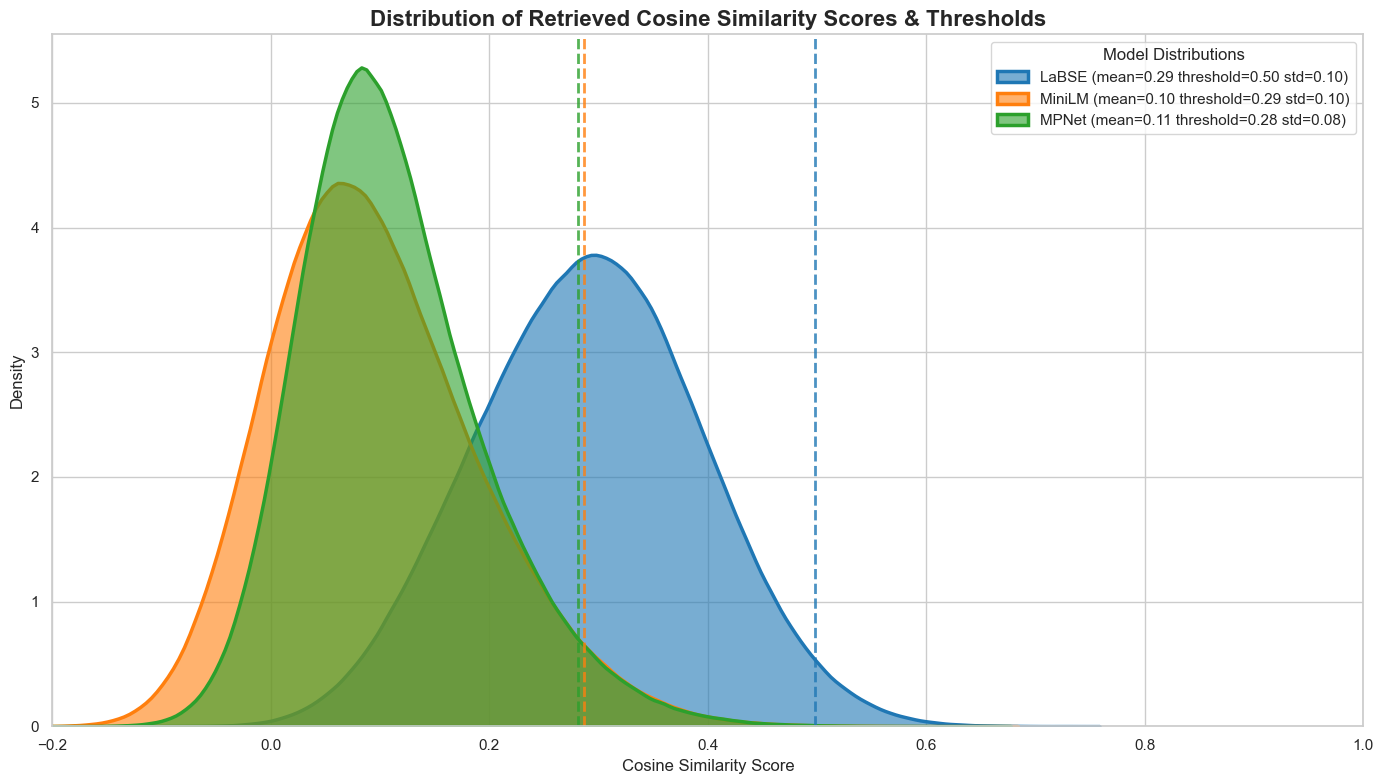

In [11]:
import matplotlib.pyplot as plt

df_vis = final_export_df #reading the normalized results for visualization

import seaborn as sns #We will use seaborn for better visualizations, Reference: https://seaborn.pydata.org/tutorial.html
sns.set_theme(style="whitegrid") #setting a nice theme for the plots
models = df_vis['Model'].unique() #getting the unique model names

# Creating a single plots for models
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_title('Distribution of Retrieved Cosine Similarity Scores & Thresholds', fontsize=16, fontweight='bold')


# we to want have all cosine_similarity scores not just the top results so we need to calculate them again
viz_data = [
    ("LaBSE", model1, concept_embeddings_LaBSE, mp_embeddings_LaBSE),
    ("MiniLM", model2, concept_embeddings_MiniLM, mp_embeddings_MiniLM),
    ("MPNet", model3, concept_embeddings_MPNet, mp_embeddings_MPNet)
]
colors = {"LaBSE": "tab:blue", "MiniLM": "tab:orange", "MPNet": "tab:green"}
#Gathering all the data for calculating the full distributions


# Loop through each model and create a histogram
for name, model, q_embs, d_embs in viz_data:  #q_embs = query embeddings, d_embs = document embeddings

    device = model.device
    q_embs = q_embs.to(device) #must all be on the same device
    d_embs = d_embs.to(device) #must all be on the same device

    #and calculating EVERY cosine similarity score
    all_scores_matrix = model.similarity(q_embs, d_embs)
    all_scores_flat = all_scores_matrix.flatten().cpu().numpy() #flattening and moving to cpu for plotting, Seaborn/matplotlib do no work with GPU tensors

    #calculating threshold for visualization
    mean_val = all_scores_flat.mean()
    std_val = all_scores_flat.std()
    threshold = mean_val + (2 * std_val)


    sns.kdeplot(  #Kernel Density Estimate plot for smooth distribution, looks better than histogram
        x=all_scores_flat, 
        color=colors.get(name, "black"), 
        linewidth=2.5,
        ax=ax,
        fill=True,
        alpha=0.6, # Transparency for better visibility
        label=f"{name} (mean={mean_val:.2f} threshold={threshold:.2f} std={std_val:.2f})"
    )
    #adding threshold line
    plt.axvline(threshold, color=colors.get(name), linestyle='--', linewidth=2, alpha=0.8)

# Some styling
plt.xlabel("Cosine Similarity Score", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xlim(-0.2, 1.0) 
plt.legend(title="Model Distributions", fontsize=11)

plt.savefig('cosine_similarity_distribution.png')
plt.tight_layout()
plt.show()